This notebook is a copy/update of the notebook used to show the feature distribution of the HST training set. The analysis here (unlike the original) uses features measured from the PS1 forced photometry measurements.

See [Figure_whiteFeatures_HST](https://github.com/adamamiller/PS1_star_galaxy/blob/master/PS1casjobs/Figure_whiteFeatures_HST.ipynb) for the original notebook. 

# White features vs Mag (HST Training Set)

In this notebook we show the distribution of 9 white features, 
which we used for constructing the machine learning model, 
as a function of magnitude for sources from PS1xHST-COSMOS cross-matched catalog. 

For obtaining a reasonable kernel density estimation (KDE), 
we excluded outliers by $10 < wwKronMag < 25$, $0 < wwPSFKronRatio < 2$, 
and $-10^{-3} < wwPSFKronDist < 10^{-3}$ from sources with $nDetection > 0$. 

In [1]:
import sys,os,math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams["font.family"] = "sans-serif"
rcParams['font.sans-serif'] = ['DejaVu Sans']
from matplotlib import gridspec as grs
%matplotlib inline
from matplotlib import cm
from astropy.table import Table
import seaborn as sns
import statsmodels.nonparametric.api as smnp
from statsmodels.nonparametric.kernel_density import KDEMultivariate
from scipy.special import expit
from scipy import stats

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib as mpl

In [2]:
ff_tab = Table.read("HST_COSMOS_Forcefeatures_adamamiller.fit").to_pandas()

The crossmatched catalog contains 80,867 sources. 

In [3]:
star, galaxy = ff_tab.MU_CLASS == 2, ff_tab.MU_CLASS == 1

In [4]:
whiteFKronMag = -2.5*np.log10(ff_tab.wwFKronFlux/3631)

In [5]:
def kde_contour_dat(x, y, extent = 'Auto', bw_type = "silverman", grid_bins = 250, BW=False):
    """Determine normalized KDE PDF to draw contours"""
    
    if isinstance(x, pd.Series):
        x = x.values
    if isinstance(y, pd.Series):
        y = y.values
    
    if extent == 'Auto':
        extent = (x.min(), x.max(), y.min(), y.max())

    if bw_type == "silverman":
        bw = np.array([smnp.bandwidths.bw_silverman(x), smnp.bandwidths.bw_silverman(y)])
    elif bw_type == "scott":
        bw = np.array([smnp.bandwidths.bw_scott(x), smnp.bandwidths.bw_scott(y)])
    if BW:
        bw = BW

    kde = KDEMultivariate([x,y], var_type='cc', bw = bw)

    xi, yi = np.mgrid[extent[0]:extent[1]:grid_bins*1j,extent[2]:extent[3]:grid_bins*1j]

    kde_prob = kde.pdf(np.vstack([xi.flatten(), yi.flatten()]))

    zi = (kde_prob-kde_prob.min())/(kde_prob.max() - kde_prob.min())
    zi = zi.reshape(xi.shape)

    return xi, yi, zi

Selecting sources with nDetections > 0, and then exclude outlier to obtain a reasonable kernel density distribution. 

In [6]:
Det_mask = ff_tab.nDetections > 0
PsfKronRatio_mask = np.logical_and(0<ff_tab.wwFPSFKronRatio, ff_tab.wwFPSFKronRatio<2)
KronMag_mask = np.logical_and(10<whiteFKronMag, whiteFKronMag<25)
PsfKronDist_mask = np.logical_and(-1e-3<ff_tab.wwFPSFKronDist, ff_tab.wwFPSFKronDist<1e-3)

In [7]:
mask = Det_mask & PsfKronRatio_mask & KronMag_mask & PsfKronDist_mask

In [8]:
xgal_Ratio, ygal_Ratio, zgal_Ratio = kde_contour_dat(whiteFKronMag[mask&galaxy], ff_tab.wwFPSFKronRatio[mask&galaxy])
xstar_Ratio, ystar_Ratio, zstar_Ratio = kde_contour_dat(whiteFKronMag[mask&star], ff_tab.wwFPSFKronRatio[mask&star])

/Users/adamamiller/miniconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [9]:
star_norm = len(ff_tab.loc[mask&star])*1.0/len(ff_tab.loc[mask])
galaxy_norm = len(ff_tab.loc[mask&galaxy])*1.0/len(ff_tab.loc[mask])

### The distribution of white features (except for wwFpsfKronDist and wwFPSFApDist) 

/Users/adamamiller/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if __name__ == '__main__':


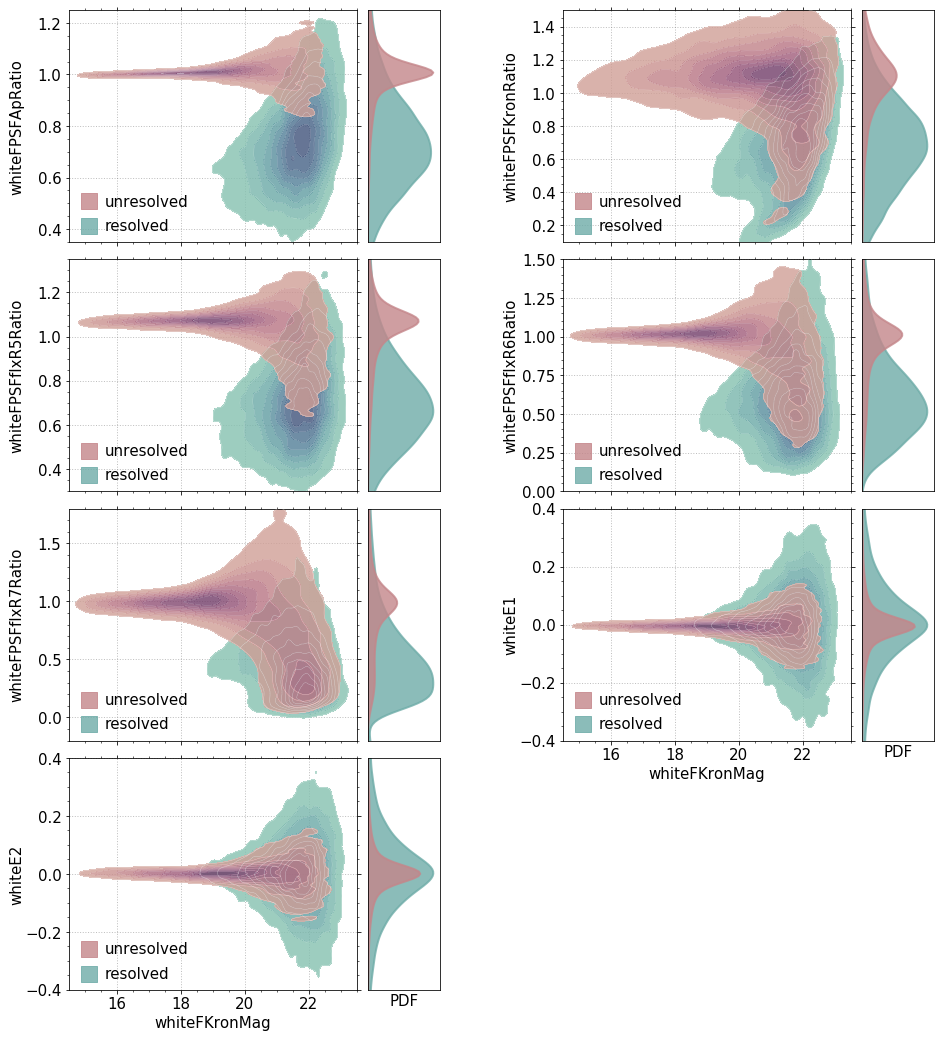

In [10]:
plt_feat = ['wwFPSFApRatio', 'wwFPSFKronRatio', 
            'wwFPSFflxR5Ratio', 'wwFPSFflxR6Ratio', 'wwFPSFflxR7Ratio',
            'wwE1', 'wwE2']
ylims_list = [ [0.35, 1.25], [0.1, 1.5],
               [0.3, 1.35], [0.0, 1.5], [-0.2,1.8], 
               [-0.4,0.4], [-0.4,0.4]
             ]
num_feat = len(plt_feat)

origin = 'lower'
levels = np.arange(0.1, 1.1, 0.1)
cmap_star = sns.cubehelix_palette(rot=0.5, light=0.7,dark=0.3,as_cmap=True)
cmap_gal = sns.cubehelix_palette(start=0.3,rot=-0.5,light=0.7,dark=0.3,as_cmap=True)

gs = grs.GridSpec(int((num_feat+1)/2), 6, width_ratios=(0.7, 4, 1, 1.4, 4, 1))
plt.figure(figsize=(13, 14.4))
plt.subplots_adjust(wspace=0.075, hspace=0.075, 
                    left=0.005, right=0.995, 
                    bottom=0.045, top=0.99)
ax = []
i = 0
for ind in range(3*num_feat):
    ax.append(plt.subplot(gs[i, ind%6]))
    if ind%6==5:
        i += 1

xlims = [14.5, 23.5]

row_num = 0
for i,name in enumerate(plt_feat):
    
    ylims = ylims_list[i]
    
    #xkernel_size = (xlims[1] - xlims[0])/10
    #ykernel_size = (ylims[1] - ylims[0])/10
    
    xgal_, ygal_, zgal_ = kde_contour_dat(whiteFKronMag[mask&galaxy&(~np.isnan(ff_tab[name]))&(~np.isinf(ff_tab[name]))], 
                                          ff_tab[name][mask&galaxy&(~np.isnan(ff_tab[name]))&(~np.isinf(ff_tab[name]))], 
                                         extent = np.r_[xlims, ylims])
    xstar_, ystar_, zstar_ = kde_contour_dat(whiteFKronMag[mask&star&(~np.isnan(ff_tab[name]))&(~np.isinf(ff_tab[name]))],
                                             ff_tab[name][mask&star&(~np.isnan(ff_tab[name]))&(~np.isinf(ff_tab[name]))], 
                                            extent = np.r_[xlims, ylims])

    ax[row_num+1].contourf(xgal_, ygal_, zgal_, levels = levels,
                           origin = origin,
                           cmap = cmap_gal, alpha = 0.8,)
    ax[row_num+1].contour(xgal_, ygal_, zgal_, levels = levels,
                        linewidths=(0.5,), origin = origin,
                        colors = ("w",), alpha = 0.5, zorder = 11)
    ax[row_num+1].contourf(xstar_, ystar_, zstar_, levels = levels,  
                           origin = origin,
                           cmap = cmap_star, alpha = 0.8)
    ax[row_num+1].contour(xstar_, ystar_, zstar_, levels = levels,
                        linewidths=(0.5,), origin = origin,
                        colors = ("w",), alpha = 0.5, zorder = 11)  
    ax[row_num+1].set_xlim(xlims); ax[row_num+1].set_ylim(ylims)
    ax[row_num+1].tick_params(labelsize = 15)
    ax[row_num+1].tick_params(which='both', top=True, right=True)
    ax[row_num+1].set_xticks(np.arange(16, 24, 2))
    ax[row_num+1].minorticks_on()
    ax[row_num].text(-0.2 + 0.6*(i % 2),
                     np.mean(ylims),name.replace('ww', 'white'), 
                     ha='center', va='center', rotation=90, fontsize=15)
    ax[row_num].set_xlim(-0.5, 1); ax[row_num].set_ylim(ylims)
    ax[row_num].axis('off')

    ax[row_num+1].grid(alpha=0.5, lw=1, c='grey', linestyle=':') 
    ax[row_num+1].set_axisbelow(True)


    ax[row_num+1].scatter(0.07*np.diff(xlims)[0] + xlims[0], 
                          0.175*np.diff(ylims)[0] + ylims[0], 
                          marker=',', s=275, color=cmap_star(0.25), alpha=0.8)
    ax[row_num+1].scatter(0.07*np.diff(xlims)[0] + xlims[0], 
                          0.07*np.diff(ylims)[0] + ylims[0], 
                          marker=',', s=275, color=cmap_gal(0.25), alpha=0.8)
    ax[row_num+1].text(0.125*np.diff(xlims)[0] + xlims[0], 
                       0.175*np.diff(ylims)[0] + ylims[0], 
                       'unresolved', ha = 'left', va = 'center', fontsize=15)
    ax[row_num+1].text(0.125*np.diff(xlims)[0] + xlims[0], 
                       0.07*np.diff(ylims)[0] + ylims[0], 
                       'resolved', ha = 'left', va = 'center', fontsize=15)

    #ax[row_num+1].set_axisbelow(True)
    if i-len(plt_feat) >= -2:
        ax[row_num+1].set_xlabel('whiteFKronMag', fontsize=15)
    else: 
        ax[row_num+1].tick_params(labelbottom="off", labeltop='off')
        ax[row_num+1].set_xticklabels( () )
        

    n = (np.arange(ylims[0]-np.abs(ylims[1]-ylims[0])*2, ylims[1]+np.abs(ylims[1]-ylims[0])*2, np.abs(ylims[1]-ylims[0])/100))
    #print(n)
    if ylims[0]<0:
        range_mask  = (ylims[0]*2 < ff_tab[name]) & (ff_tab[name] < ylims[1]*2)
    else: 
        range_mask  = (ylims[0]/2 < ff_tab[name]) & (ff_tab[name] < ylims[1]*2)
    kde_Star_ = stats.gaussian_kde(np.array(ff_tab[name][mask&star&(~np.isnan(ff_tab[name]))&(~np.isinf(ff_tab[name]))&range_mask]), 
                                  bw_method='silverman')
    kde_Gal_ = stats.gaussian_kde(np.array(ff_tab[name][mask&galaxy&(~np.isnan(ff_tab[name]))&(~np.isinf(ff_tab[name]))&range_mask]), 
                                 bw_method='silverman')
    ax[row_num+2].fill_betweenx(n, kde_Gal_(n)*galaxy_norm, alpha=0.8, color=cmap_gal(0.25), lw=2)
    ax[row_num+2].fill_betweenx(n, kde_Star_(n)*star_norm, alpha=0.8, color=cmap_star(0.25), lw=2)
    ax[row_num+2].set_ylim(ylims)
    ax[row_num+2].set_xlim(0, 1.1*np.max(np.r_[kde_Gal_(n)*galaxy_norm, kde_Star_(n)*star_norm]))
    ax[row_num+2].set_xticklabels( () )
    ax[row_num+2].set_yticklabels( () )
    ax[row_num+2].set_xticks([])
    ax[row_num+2].set_yticks([])
    ax[row_num+2].tick_params(which='both', left='off')
    ax[row_num+2].minorticks_on()
    #ax[row_num+2].set_axisbelow(True)
    if i-len(plt_feat) >= -2:
        ax[row_num+2].set_xlabel('PDF', fontsize=15)
        
    row_num += 3
    
# plt.tight_layout()
plt.savefig('../paperII/figures/whiteFeatures.pdf', pad_inches=0.5)

### Correlation matrix of white features

In [11]:
wwfeatures = ['wwFPSFApRatio', 'wwFPSFKronRatio', 
              'wwFPSFflxR5Ratio', 'wwFPSFflxR6Ratio', 'wwFPSFflxR7Ratio',
              'wwE1', 'wwE2',
              'wwFPSFApDist', 'wwFPSFKronDist']


In [12]:
def delete_ww(str_array):
    string = ",".join(str_array)
    string_new = string.replace('ww', '')
    str_list_new =  string_new.split(",")
    return(str_list_new)

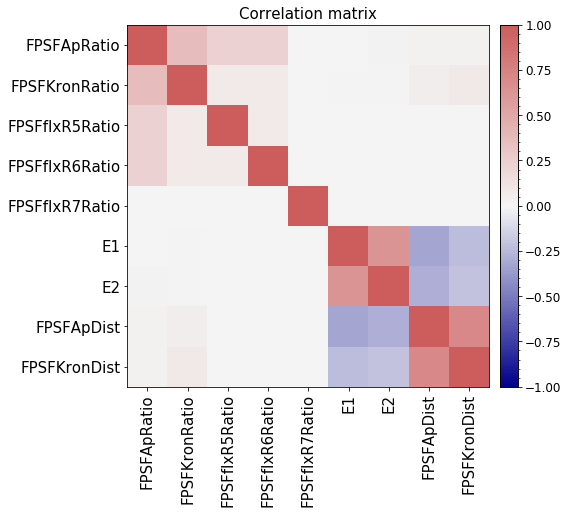

In [13]:
import mpl_toolkits.axes_grid1
from matplotlib.colors import LinearSegmentedColormap

def generate_cmap(colors):
    values = range(len(colors))

    vmax = np.ceil(np.max(values))
    color_list = []
    for v, c in zip(values, colors):
        color_list.append( ( v/ vmax, c) )
    return LinearSegmentedColormap.from_list('custom_cmap', color_list)

cm = generate_cmap(['darkblue',  'whitesmoke', 'indianred'])


def correlation_matrix(df):

    fig = plt.figure(figsize=(8, 8))
    ax1 = fig.add_subplot(111)
    ax1.tick_params(bottom="off", left='off')
    cmap = cm
    cax = ax1.imshow(df.corr(), interpolation="nearest", cmap=cmap, vmin=-1, vmax=1)
    #ax1.grid(True)
    plt.title('Correlation matrix', fontsize=15)
    labels=delete_ww(ff_tab[wwfeatures].columns.values)
    ax1.set_xticks(range(0, len(labels)))
    ax1.set_yticks(range(0, len(labels)))
    ax1.set_xticklabels(labels,fontsize=15, rotation =90)
    ax1.set_yticklabels(labels,fontsize=15)
    divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax1)
    cax_ = divider.append_axes('right', '5%', pad='3%')
    plt.colorbar(cax, ticks=np.arange(-1, 1.25, 0.25), cax=cax_).ax.tick_params(labelsize=12)
    plt.colorbar(cax, ticks=np.arange(-1, 1.25, 0.25), cax=cax_).ax.minorticks_on()
    plt.tight_layout()

correlation_matrix(ff_tab[wwfeatures])
# plt.savefig('CorrelationMatrix.pdf', pad_inches=0.5)

The correlation between features in this model is relatively weak. $E1$ and $E2$ have a strong correlation (as expected), while $\mathtt{whiteFPSFApDist}$ $\mathtt{whiteFPSFKronDist}$ have the strong correlation of any other features. This too can be expected as obvious galaxies have negative values in both these parameters. 

### The simple separation model (wwpsfKronDist)

By calculating the distance from the threshold on the wwPSFFlux-wwKronFlux plane, we attached a score to each object for using it as the star/galaxy separator (we will call it as Simple model in the paper).  

/Users/adamamiller/miniconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


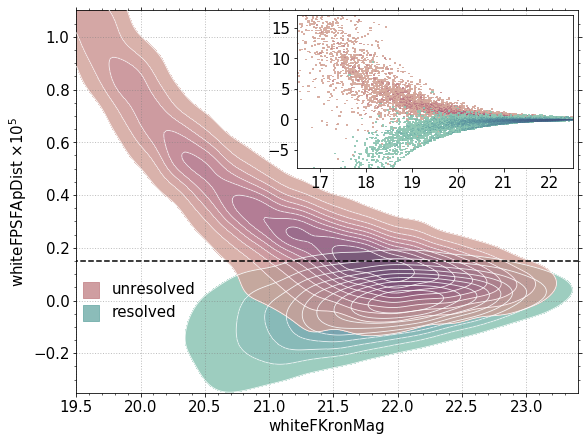

In [14]:
fac=1e5

xlims = [19.5, 23.4]
ylims = np.array([-0.35e-5, 1.1e-5])*fac

cmap_star = sns.cubehelix_palette(rot=0.5, light=0.7,dark=0.3,as_cmap=True)
cmap_gal = sns.cubehelix_palette(start=0.3,rot=-0.5,light=0.7,dark=0.3,as_cmap=True)

fig, ax = plt.subplots(figsize=(8, 6))
axins = inset_axes(ax, width="55%",  
                   height="40%", loc=1)

ax.grid(alpha=0.5, lw=1, c='grey', linestyle=':') 
ax.tick_params(which="both", top=True, right=True)
ax.minorticks_on()

xgal_Dist, ygal_Dist, zgal_Dist = kde_contour_dat(whiteFKronMag[mask&galaxy], ff_tab.wwFPSFApDist[mask&galaxy]*fac, 
                                                     grid_bins=200, extent=(19.5, 23.5, -0.4e-5*fac, 1.2e-5*fac), BW=[0.1, 5e-7*fac])
xstar_Dist, ystar_Dist, zstar_Dist = kde_contour_dat(whiteFKronMag[mask&star], ff_tab.wwFPSFApDist[mask&star]*fac, 
                                                        grid_bins=200, extent=(19.5, 23.5,  -0.4e-5*fac, 1.2e-5*fac), BW=[0.1, 5e-7*fac])

ax.contourf(xgal_Dist, ygal_Dist, zgal_Dist, levels = levels,
             origin = origin,
             cmap = cmap_gal, alpha = 0.8)
ax.contour(xgal_Dist, ygal_Dist, zgal_Dist, levels = levels,
                    linewidths=(0.85,), origin = origin,
                    colors = ("w",), alpha = 0.9, zorder = 11)
ax.contourf(xstar_Dist, ystar_Dist, zstar_Dist, levels = levels,  
               origin = origin,
               cmap = cmap_star, alpha = 0.8)
ax.contour(xstar_Dist, ystar_Dist, zstar_Dist, levels = levels,
                    linewidths=(0.85,), origin = origin,
                    colors = ("w",), alpha = 0.9, zorder = 11)  

ax.set_xlim(xlims); ax.set_ylim(ylims)
ax.tick_params(labelsize = 15)
ax.set_xlabel('whiteFKronMag', fontsize=15)
ax.set_ylabel('whiteFPSFApDist ×$10^5$', fontsize=15)

ax.scatter(0.03*np.diff(xlims)[0] + xlims[0], 
                      0.27*np.diff(ylims)[0] + ylims[0], 
                      marker=',', s=275, color=cmap_star(0.25), alpha=0.8)
ax.scatter(0.03*np.diff(xlims)[0] + xlims[0], 
                      0.21*np.diff(ylims)[0] + ylims[0], 
                      marker=',', s=275, color=cmap_gal(0.25), alpha=0.8)
ax.text(0.07*np.diff(xlims)[0] + xlims[0], 
                   0.27*np.diff(ylims)[0] + ylims[0], 
                   'unresolved', ha = 'left', va = 'center', fontsize=15)
ax.text(0.07*np.diff(xlims)[0] + xlims[0], 
                   0.21*np.diff(ylims)[0] + ylims[0], 
                   'resolved', ha = 'left', va = 'center', fontsize=15)
ax.hlines(1.48485e-6*fac, 10, 30,  colors='k', linestyles='dashed', linewidth=1.5, zorder=12)


gridsize = 250
xlims = [16.5, 22.5]
ylims = np.array([-0.8e-4, 0.17e-3])*fac

origin = 'lower'
levels = np.arange(0.1, 1.1, 0.1)
cmap_star = sns.cubehelix_palette(rot=0.5, light=0.7,dark=0.3,as_cmap=True)
cmap_gal = sns.cubehelix_palette(start=0.3,rot=-0.5,light=0.7,dark=0.3,as_cmap=True)
axins.grid(alpha=0.5, lw=1, c='grey', linestyle=':') 

axins.hist2d(whiteFKronMag[mask&galaxy], ff_tab.wwFPSFKronDist[mask&galaxy]*fac, 
            bins=[np.linspace(16.5, 22.5, gridsize), np.linspace(ylims[0], ylims[1], gridsize)], 
            norm=mpl.colors.LogNorm(), 
            cmap=cmap_gal, alpha=0.9, zorder=11)
axins.hist2d(whiteFKronMag[mask&star], ff_tab.wwFPSFKronDist[mask&star]*fac, 
            bins=[np.linspace(16.5, 22.5, gridsize), np.linspace(ylims[0], ylims[1], gridsize)], 
            norm=mpl.colors.LogNorm(), 
            cmap=cmap_star, alpha=0.9)



axins.set_yticks(np.arange(-5, 20, 5))
axins.set_xticks(np.arange(17, 23, 1))
axins.set_xlim(xlims); axins.set_ylim(ylims)
axins.tick_params(labelsize = 15)

plt.subplots_adjust(left=0.12, right=0.99, bottom=0.1, top=0.985)
plt.savefig('../paperII/figures/whiteFPSFApDist.pdf')

/Users/adamamiller/miniconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


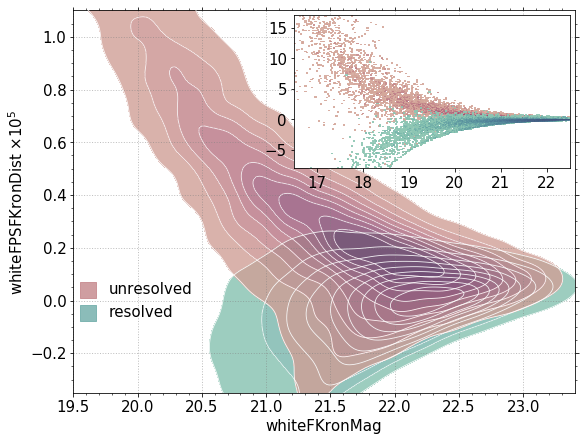

In [15]:
fac=1e5

xlims = [19.5, 23.4]
ylims = np.array([-0.35e-5, 1.1e-5])*fac

cmap_star = sns.cubehelix_palette(rot=0.5, light=0.7,dark=0.3,as_cmap=True)
cmap_gal = sns.cubehelix_palette(start=0.3,rot=-0.5,light=0.7,dark=0.3,as_cmap=True)

fig, ax = plt.subplots(figsize=(8, 6))
axins = inset_axes(ax, width="55%",  
                   height="40%", loc=1)

ax.grid(alpha=0.5, lw=1, c='grey', linestyle=':') 
ax.tick_params(which="both", top=True, right=True)
ax.minorticks_on()

xgal_Dist, ygal_Dist, zgal_Dist = kde_contour_dat(whiteFKronMag[mask&galaxy], ff_tab.wwFPSFKronDist[mask&galaxy]*fac, 
                                                     grid_bins=200, extent=(19.5, 23.5, -0.4e-5*fac, 1.2e-5*fac), BW=[0.1, 5e-7*fac])
xstar_Dist, ystar_Dist, zstar_Dist = kde_contour_dat(whiteFKronMag[mask&star], ff_tab.wwFPSFKronDist[mask&star]*fac, 
                                                        grid_bins=200, extent=(19.5, 23.5,  -0.4e-5*fac, 1.2e-5*fac), BW=[0.1, 5e-7*fac])

ax.contourf(xgal_Dist, ygal_Dist, zgal_Dist, levels = levels,
             origin = origin,
             cmap = cmap_gal, alpha = 0.8)
ax.contour(xgal_Dist, ygal_Dist, zgal_Dist, levels = levels,
                    linewidths=(0.85,), origin = origin,
                    colors = ("w",), alpha = 0.9, zorder = 11)
ax.contourf(xstar_Dist, ystar_Dist, zstar_Dist, levels = levels,  
               origin = origin,
               cmap = cmap_star, alpha = 0.8)
ax.contour(xstar_Dist, ystar_Dist, zstar_Dist, levels = levels,
                    linewidths=(0.85,), origin = origin,
                    colors = ("w",), alpha = 0.9, zorder = 11)  

# ax.hlines(9.199338089095014e-07*fac, 10, 30,  colors='k', linestyles='dashed', linewidth=1.5, zorder=12)

ax.set_xlim(xlims); ax.set_ylim(ylims)
ax.tick_params(labelsize = 15)
ax.set_xlabel('whiteFKronMag', fontsize=15)
ax.set_ylabel('whiteFPSFKronDist ×$10^5$', fontsize=15)

ax.scatter(0.03*np.diff(xlims)[0] + xlims[0], 
                      0.27*np.diff(ylims)[0] + ylims[0], 
                      marker=',', s=275, color=cmap_star(0.25), alpha=0.8)
ax.scatter(0.03*np.diff(xlims)[0] + xlims[0], 
                      0.21*np.diff(ylims)[0] + ylims[0], 
                      marker=',', s=275, color=cmap_gal(0.25), alpha=0.8)
ax.text(0.07*np.diff(xlims)[0] + xlims[0], 
                   0.27*np.diff(ylims)[0] + ylims[0], 
                   'unresolved', ha = 'left', va = 'center', fontsize=15)
ax.text(0.07*np.diff(xlims)[0] + xlims[0], 
                   0.21*np.diff(ylims)[0] + ylims[0], 
                   'resolved', ha = 'left', va = 'center', fontsize=15)


gridsize = 250
xlims = [16.5, 22.5]
ylims = np.array([-0.8e-4, 0.17e-3])*fac

origin = 'lower'
levels = np.arange(0.1, 1.1, 0.1)
cmap_star = sns.cubehelix_palette(rot=0.5, light=0.7,dark=0.3,as_cmap=True)
cmap_gal = sns.cubehelix_palette(start=0.3,rot=-0.5,light=0.7,dark=0.3,as_cmap=True)
axins.grid(alpha=0.5, lw=1, c='grey', linestyle=':') 

axins.hist2d(whiteFKronMag[mask&galaxy], ff_tab.wwFPSFKronDist[mask&galaxy]*fac, 
            bins=[np.linspace(16.5, 22.5, gridsize), np.linspace(ylims[0], ylims[1], gridsize)], 
            norm=mpl.colors.LogNorm(), 
            cmap=cmap_gal, alpha=0.9, zorder=11)
axins.hist2d(whiteFKronMag[mask&star], ff_tab.wwFPSFKronDist[mask&star]*fac, 
            bins=[np.linspace(16.5, 22.5, gridsize), np.linspace(ylims[0], ylims[1], gridsize)], 
            norm=mpl.colors.LogNorm(), 
            cmap=cmap_star, alpha=0.9)

axins.set_yticks(np.arange(-5, 20, 5))
axins.set_xticks(np.arange(17, 23, 1))
axins.set_xlim(xlims); axins.set_ylim(ylims)
axins.tick_params(labelsize = 15)

plt.subplots_adjust(left=0.12, right=0.99, bottom=0.1, top=0.985)
plt.savefig('../paperII/figures/whiteFPSFKronDist.pdf')